# 코로나 확진자 추세에 따른 카드매출발생금액 예측
(1) 코로나 환자의 역학 데이터 전처리 및 시각화

## Data description
`PatientInfo.csv` 한국 코로나 환자의 역학 데이터
- `patient_id` : 환자의 ID
    - patient_id = region_code(5) + patient_number(5)
    - patient_number
        - local_num : 지방자치단체가 부여한 번호
        - global_num : KCDC에서 부여한 번호
- `infections_case` : 감염사례
- `infected by` : 환자를 감염시킨 사람의 ID
- `contact_number` : 사람과 접촉 수
- `symptom_onset_date` : 증상이 발생한 날짜
- `confirmed_date` : 확인일
- `released_date` : 퇴원일
- `deceased_date` : 사망일
- `state`
    - isolated : 병원에 격리됨
    - released : 병원에서 퇴원함
    - deceased : 사망

데이터 출처: [Kaggle-Data Science for COVID-19 (DS4S)](https://www.kaggle.com/kimjihoo/coronavirusdataset?select=TimeProvince.csv)

## Preprocessing

In [1]:
# import required packages
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.rc('font', family='AppleGothic')

In [2]:
# directory
current_path = os.getcwd()
data_DIR = os.path.join(current_path, 'data')
output_DIR = os.path.join(current_path, 'output')


# data path
pinfo_path = os.path.join(data_DIR, 'COVID', 'PatientInfo.csv')


# load data
pinfo_df = pd.read_csv(pinfo_path)

In [3]:
# check dataframe
pinfo_df.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [4]:
# check datatype
pinfo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


In [5]:
# number of missing values
print('전체 레코드 수:', len(pinfo_df))
pinfo_df.isnull().sum()

전체 레코드 수: 5165


patient_id               0
sex                   1122
age                   1380
country                  0
province                 0
city                    94
infection_case         919
infected_by           3819
contact_number        4374
symptom_onset_date    4475
confirmed_date           3
released_date         3578
deceased_date         5099
state                    0
dtype: int64

<AxesSubplot:>

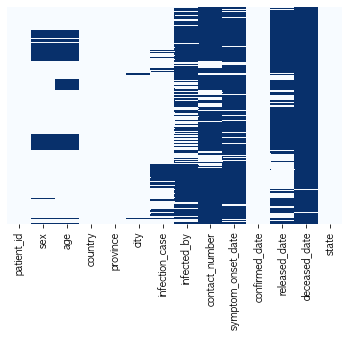

In [6]:
# missing values
sns.heatmap(pinfo_df.isnull(), yticklabels=False, cbar=False, cmap='Blues')

In [7]:
# drop unnecessary columns
pinfo_df = pinfo_df.drop(columns = ['infected_by', 'contact_number', 'symptom_onset_date',
                                    'released_date', 'deceased_date'])

In [8]:
# proportion of leftfover missing values
def missing_per(col):
    missing = pinfo_df[col].isnull().sum()
    return round(missing/len(pinfo_df), 2)*100

print('연령대 결측치 비율:', missing_per('age')) # fill since age has many categories
print('성별 결측치 비율:', missing_per('sex'))  # predict
print('도시 결측치 비율:', missing_per('city')) # drop
print('감염사례 결측치 비율:', missing_per('infection_case')) # fill

연령대 결측치 비율: 27.0
성별 결측치 비율: 22.0
도시 결측치 비율: 2.0
감염사례 결측치 비율: 18.0


In [9]:
# filling missing values
pinfo_df.age = pinfo_df.age.fillna('unknown')
pinfo_df.infection_case = pinfo_df.infection_case.fillna('etc')

In [10]:
# predict missing values in sex using logistic regression

# copy dataframe for prediction (deep copy)
copy_df = pinfo_df.copy()


# unique values
# using only province to prevent multicollinearity
print(len(copy_df.country.unique()))
print(len(copy_df.province.unique()))
print(len(copy_df.city.unique()))


# drop unnecessary columns
copy_df = copy_df.drop(columns=['age', 'country', 'city', 'confirmed_date'])


# create dummy variables
sex = pd.get_dummies(copy_df['sex'], drop_first=True)
province = pd.get_dummies(copy_df['province'], drop_first=True)
infection_case = pd.get_dummies(copy_df['infection_case'], drop_first=True)
state = pd.get_dummies(copy_df['state'], drop_first=True)


# merge dummy variabales and drop original columns
copy_df = copy_df.join(sex).join(province).join(infection_case).join(state)
copy_df = copy_df.drop(columns=['province','infection_case','state'])


# data partition
sex_null = copy_df[copy_df['sex'].isnull()]
pre_x = sex_null.drop(columns=['sex', 'male'])
pre_y = sex_null['male']

copy_df = copy_df.drop(columns=['sex'])
x = copy_df.drop(columns=['male'])
y = copy_df['male']


# create and train model
model = LogisticRegression()
model.fit(x, y)


# predict sex
prediction = model.predict(pre_x)


# check sex
sex_df = pd.DataFrame(prediction)
sex_df = sex_df.rename(columns={0:'male'})
sex_df.male.value_counts()

16
17
164


0    1122
Name: male, dtype: int64

선형 회귀를 이용한 성별 예측 실패
- 전체를 여성 (`0`)으로 예측
- 20/12/14 기준 질병관리청 현황 파악 - 여성 52%, 남성 48%

<img src='sex_201217.jpg' width='400'>

- 결측치를 랜덤 추출하여 비율대로 채우기

In [11]:
# proportion of missing values in sex
female_num = len(pinfo_df[pinfo_df['sex']=='female'])
male_num = len(pinfo_df[pinfo_df['sex']=='male'])
print('여성 비율:', round(female_num/len(pinfo_df), 2)*100)
print('남성 비율:', round(male_num/len(pinfo_df), 2)*100)

여성 비율: 43.0
남성 비율: 35.0


In [12]:
# number of missing values to be filled
female_na = int(len(pinfo_df)*0.52)-female_num
male_na = pinfo_df.sex.isnull().sum()-female_na
print('채워야 할 여성 레코드 수:', female_na)
print('채워야 할 남성 레코드 수:', male_na)

채워야 할 여성 레코드 수: 467
채워야 할 남성 레코드 수: 655


In [13]:
# random sampling
random_male = pinfo_df[pinfo_df.sex.isnull()].sample(650)


# filling missing values
# create and convert dummy variable (0 for female, 1 for male)
random_male = random_male.rename(columns={'sex':'male_dum'})
random_male['male_dum'] = random_male['male_dum'].fillna(1)
random_male = random_male['male_dum']

male = pd.get_dummies(pinfo_df['sex'], drop_first=True)
pinfo_df = pinfo_df.drop(columns=['sex']).join(male)


# merge dataframe
pinfo_df = pinfo_df.join(random_male)


# female
pinfo_df.male_dum = pinfo_df.male_dum.fillna(0)


# merge male column
pinfo_df['male'] = pinfo_df['male']+pinfo_df['male_dum']
pinfo_df = pinfo_df.drop(columns=['male_dum'])

In [14]:
# proportion of missing values in sex
female_num = len(pinfo_df[pinfo_df['male']==0])
male_num = len(pinfo_df[pinfo_df['male']==1])
print('여성 비율:', round(female_num/len(pinfo_df), 2)*100)
print('남성 비율:', round(male_num/len(pinfo_df), 2)*100)

여성 비율: 52.0
남성 비율: 48.0


In [15]:
# analyze only data whose province is Seoul
pinfo_df = pinfo_df[pinfo_df['province']=='Seoul']
print('서울 레코드 수:', len(pinfo_df))

서울 레코드 수: 1312


In [16]:
# check city name
print(pinfo_df['city'].unique())
print(len(pinfo_df[pinfo_df['city']=='etc']))

['Gangseo-gu' 'Jungnang-gu' 'Jongno-gu' 'Mapo-gu' 'Seongbuk-gu' 'etc'
 'Songpa-gu' 'Seodaemun-gu' 'Seongdong-gu' 'Seocho-gu' 'Guro-gu'
 'Gangdong-gu' 'Eunpyeong-gu' 'Geumcheon-gu' 'Gwanak-gu' 'Nowon-gu'
 'Dongjak-gu' 'Gangnam-gu' 'Yangcheon-gu' 'Gwangjin-gu' 'Dongdaemun-gu'
 'Yeongdeungpo-gu' 'Dobong-gu' 'Yongsan-gu' 'Gangbuk-gu' 'Jung-gu']
80


In [17]:
# drop etc records
print('전체 레코드 수:', len(pinfo_df))

etc_idx = pinfo_df[pinfo_df['city']=='etc'].index
pinfo_df.drop(etc_idx, inplace=True)

print('etc 제거 후 레코드 수:', len(pinfo_df))

전체 레코드 수: 1312
etc 제거 후 레코드 수: 1232


In [18]:
# drop missing values
print('전체 레코드 수:', len(pinfo_df))
pinfo_df = pinfo_df.dropna(subset=['city', 'confirmed_date'], axis=0)
print('결측치 제거 후 레코드 수:', len(pinfo_df))

전체 레코드 수: 1232
결측치 제거 후 레코드 수: 1232


In [19]:
# change city name to Korean
eng_list = [pinfo_df['city']=='Gangseo-gu',       #강서구
            pinfo_df['city']=='Jungnang-gu',      #중랑구
            pinfo_df['city']=='Jongno-gu',        #종로구
            pinfo_df['city']=='Mapo-gu',          #마포구
            pinfo_df['city']=='Seongbuk-gu',      #성북구
            pinfo_df['city']=='Songpa-gu',        #송파구
            pinfo_df['city']=='Seodaemun-gu',     #서대문구
            pinfo_df['city']=='Seongdong-gu',     #성동구
            pinfo_df['city']=='Seocho-gu',        #서초구
            pinfo_df['city']=='Guro-gu',          #구로구
            pinfo_df['city']=='Gangdong-gu',      #강동구
            pinfo_df['city']=='Eunpyeong-gu',     #은평구
            pinfo_df['city']=='Geumcheon-gu',     #금천구
            pinfo_df['city']=='Gwanak-gu',        #관악구
            pinfo_df['city']=='Nowon-gu',         #노원구
            pinfo_df['city']=='Dongjak-gu',       #동작구
            pinfo_df['city']=='Gangnam-gu',       #관악구
            pinfo_df['city']=='Yangcheon-gu',     #양천구
            pinfo_df['city']=='Gwangjin-gu',      #광진구
            pinfo_df['city']=='Dongdaemun-gu',    #동대문구
            pinfo_df['city']=='Yeongdeungpo-gu',  #영등포구
            pinfo_df['city']=='Dobong-gu',        #도봉구
            pinfo_df['city']=='Yongsan-gu',       #용산구
            pinfo_df['city']=='Gangbuk-gu',       #강북구
            pinfo_df['city']=='Jung-gu']          #중구
kor_list = ['강서구','중랑구','종로구','마포구','성북구','송파구','서대문구','성동구',
           '서초구','구로구','강동구','은평구','금천구','관악구','노원구','동작구',
           '관악구','양천구','광진구','동대문구','영등포구','도봉구','용산구','강북구','중구']

pinfo_df['city_nm'] = np.select(eng_list, kor_list, default='Not Specified')
pinfo_df.city_nm.value_counts()

관악구     196
구로구      85
강서구      78
양천구      71
도봉구      62
영등포구     62
서초구      55
송파구      55
동작구      53
은평구      53
용산구      50
성동구      49
노원구      43
마포구      38
동대문구     38
서대문구     36
강동구      35
중랑구      33
성북구      33
금천구      32
강북구      24
종로구      22
광진구      17
중구       12
Name: city_nm, dtype: int64

`np.select()` : 조건문에 따라 배열과 리스트 매칭

참고: [Pandas에서 주어진 조건에 따라 DataFrame 열을 만드는 방법](https://www.delftstack.com/ko/howto/python-pandas/how-to-create-dataframe-column-based-on-given-condition-in-pandas/)

In [20]:
# convert datetime
pinfo_df['confirmed_date'] = pd.to_datetime(pinfo_df['confirmed_date'], format='%Y-%m-%d')

print('시작일:', pinfo_df['confirmed_date'].min())
print('종료일:', pinfo_df['confirmed_date'].max())

시작일: 2020-01-23 00:00:00
종료일: 2020-06-29 00:00:00


In [21]:
# rearrangement column and index order
pinfo_df = pinfo_df[['patient_id','age','male','city_nm','infection_case','confirmed_date','state']]
pinfo_df = pinfo_df.reset_index(drop=True)

In [22]:
# check dataframe
pinfo_df.head()

,patient_id,age,male,city_nm,infection_case,confirmed_date,state
0,1000000001,50s,1.0,강서구,overseas inflow,2020-01-23,released
1,1000000002,30s,1.0,중랑구,overseas inflow,2020-01-30,released
2,1000000003,50s,1.0,종로구,contact with patient,2020-01-30,released
3,1000000004,20s,1.0,마포구,overseas inflow,2020-01-30,released
4,1000000005,20s,0.0,성북구,contact with patient,2020-01-31,released


## Visualization

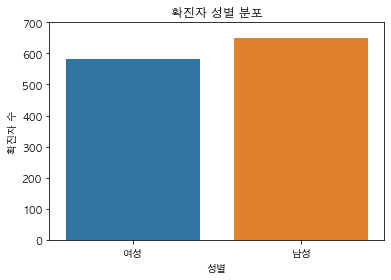

In [23]:
# sex
plt.figure(figsize=(6, 4))
sns.countplot(x='male', data=pinfo_df)
plt.title('확진자 성별 분포')
plt.xlabel('성별')
plt.ylabel('확진자 수')
plt.yticks(np.arange(0, 701, 100))
plt.xticks([0,1], ['여성','남성']);

plt.savefig(output_DIR+'/확진자수_성별.png')

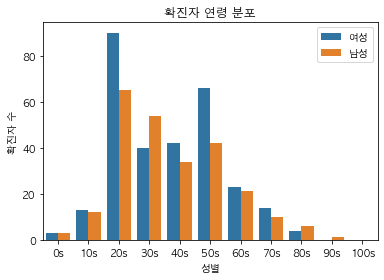

In [24]:
# age
plt.figure(figsize=(6, 4))
sns.countplot(x='age', data=pinfo_df, hue='male',
              order=['0s','10s','20s','30s','40s','50s','60s','70s','80s','90s','100s'])
plt.title('확진자 연령 분포')
plt.xlabel('성별')
plt.ylabel('확진자 수')
plt.legend(['여성', '남성'], loc='upper right');

plt.savefig(output_DIR+'/확진자수_연령.png')

In [25]:
# check the reason for the high infection rate in 20s and 50s
pinfo_df[pinfo_df['age']=='20s'].infection_case.value_counts()
# pinfo_df[pinfo_df['age']=='50s'].infection_case.value_counts()

overseas inflow                  92
contact with patient             28
Guro-gu Call Center              10
etc                              10
Dongan Church                     8
Eunpyeong St. Mary's Hospital     2
Itaewon Clubs                     2
Seongdong-gu APT                  2
Shincheonji Church                1
Name: infection_case, dtype: int64

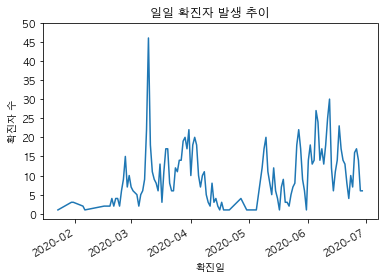

In [26]:
# number of daily confirmed patient
pinfo_df['confirmed'] = 1
daily_df = pinfo_df['confirmed'].groupby(pinfo_df['confirmed_date']).sum()
daily_df = pd.DataFrame(daily_df)

daily_df.plot(y='confirmed', figsize=(6, 4))
plt.title('일일 확진자 발생 추이')
plt.xlabel('확진일')
plt.ylabel('확진자 수')
plt.yticks(np.arange(0, 51, 5))
plt.legend([], frameon=False);

plt.savefig(output_DIR+'/일일 확진자수.png')

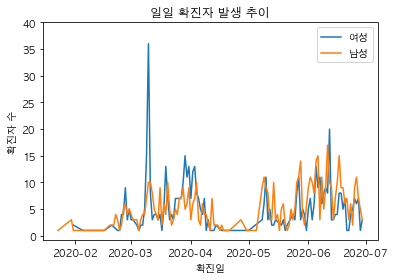

In [27]:
# number of daily confirmed patient
female = pinfo_df[pinfo_df['male']==0]
female_df = female['confirmed'].groupby(female['confirmed_date']).sum()
female_df = pd.DataFrame(female_df)

male = pinfo_df[pinfo_df['male']==1]
male_df = male['confirmed'].groupby(male['confirmed_date']).sum()
male_df = pd.DataFrame(male_df)

plt.figure(figsize=(6, 4))
plt.plot(female_df.index, female_df.confirmed, label='여성')
plt.plot(male_df.index, male_df.confirmed, label='남성')
plt.title('일일 확진자 발생 추이')
plt.xlabel('확진일')
plt.ylabel('확진자 수')
plt.yticks(np.arange(0, 41, 5))
plt.legend();

plt.savefig(output_DIR+'/일일 확진자수_성별.png')

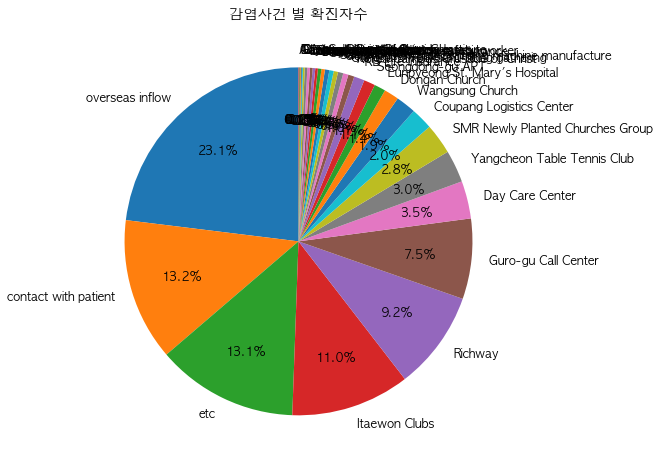

In [28]:
# infection case
case = pinfo_df['confirmed'].groupby(pinfo_df['infection_case']).sum()
case = pd.DataFrame(case)
case = case.reset_index()

case = case.sort_values(by='confirmed', ascending=False)
labels = [x for x in case['infection_case']]
ratio = [x for x in case['confirmed']]

plt.figure(figsize=(8, 8))
plt.rc('font', size=12)
plt.pie(ratio, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.7)
plt.title('감염사건 별 확진자수');

plt.savefig(output_DIR+'/감염사건별 확진자수.png')

In [29]:
# check infection case
# pinfo_df[pinfo_df['infection_case']=='Guro-gu Call Center'].head(50)
# pinfo_df[pinfo_df['infection_case']=='Itaewon Clubs'].head(50)
# pinfo_df[pinfo_df['infection_case']=='Richway'].head(50)
# pinfo_df[pinfo_df['infection_case']=='Day Care Center'].head(50)
pinfo_df['infection_case'].value_counts()

overseas inflow                                  284
contact with patient                             163
etc                                              162
Itaewon Clubs                                    136
Richway                                          113
Guro-gu Call Center                               92
Day Care Center                                   43
Yangcheon Table Tennis Club                       37
SMR Newly Planted Churches Group                  35
Coupang Logistics Center                          25
Wangsung Church                                   23
Dongan Church                                     17
Seongdong-gu APT                                  13
Eunpyeong St. Mary's Hospital                     13
KB Life Insurance                                 12
Korea Campus Crusade of Christ                     7
Geumcheon-gu rice milling machine manufacture      6
Gangnam Yeoksam-dong gathering                     6
Samsung Medical Center                        

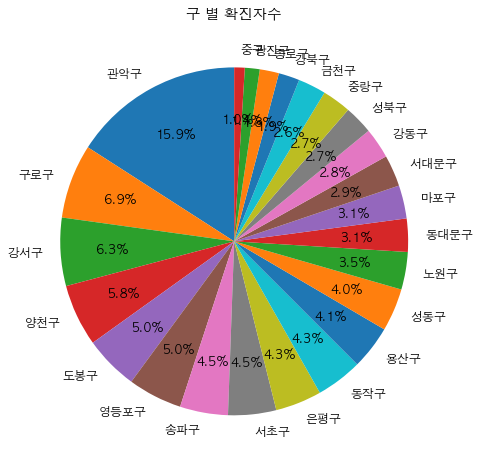

In [30]:
# city
city = pinfo_df['confirmed'].groupby(pinfo_df['city_nm']).sum()
city = pd.DataFrame(city)
city = city.reset_index()

city = city.sort_values(by='confirmed', ascending=False)
labels = [x for x in city['city_nm']]
ratio = [x for x in city['confirmed']]

plt.figure(figsize=(8, 8))
plt.rc('font', size=12)
plt.pie(ratio, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.7)
plt.title('구 별 확진자수');

plt.savefig(output_DIR+'/구별 확진자수.png')

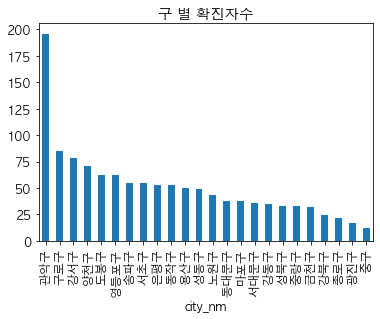

In [31]:
# city
city.set_index('city_nm').sort_values(by='confirmed', ascending=False).plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title('구 별 확진자수')
plt.legend([], frameon=False);

plt.savefig(output_DIR+'/구별 확진자수_막대.png')

`set_index()` : 데이터프레임 내 칼럼을 인덱스로 지정
- `inplace=True` 원본 객체를 변경

In [32]:
# save dataframe
pinfo_df.to_csv(output_DIR+'/pinfo_df.csv', index=False)